1. Carga y limpieza de datos

In [2]:
# Instalación de librerías necesarias (descomenta si es necesario)
# !pip install pandas numpy matplotlib seaborn scikit-learn tensorflow kaggle kagglehub

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Carga el dataset
df = pd.read_csv('loan/loan.csv')

# Mapea el target
status_map = {
    "Fully Paid": 0,
    "Charged Off": 1,
    "Late (31-120 days)": 1,
    "Default": 1,
    "Does not meet the credit policy. Status:Fully Paid": 0,
    "Does not meet the credit policy. Status:Charged Off": 1
}
df['target'] = df['loan_status'].map(status_map)
df = df[df['target'].notna()].copy()

C:\Users\User\AppData\Local\Temp\ipykernel_4772\3051664056.py:11: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('loan/loan.csv')


2. Explora el balance de clases

In [3]:
print(df['target'].value_counts())
print(df['target'].value_counts(normalize=True))

target
0.0    209711
1.0     58819
Name: count, dtype: int64
target
0.0    0.780959
1.0    0.219041
Name: proportion, dtype: float64


3. Analiza las variables por clase

In [4]:
features = [
    'last_pymnt_amnt', 'total_rec_prncp', 'funded_amnt', 'funded_amnt_inv',
    'total_pymnt_inv', 'total_pymnt', 'total_rec_int', 'out_prncp_inv', 'out_prncp'
]
print(df.groupby('target')[features].mean())

        last_pymnt_amnt  total_rec_prncp   funded_amnt  funded_amnt_inv  \
target                                                                    
0.0         7717.238363     13240.284797  13262.990973     13155.243148   
1.0          460.924482      3434.814752  14664.936075     14526.402598   

        total_pymnt_inv   total_pymnt  total_rec_int  out_prncp_inv  \
target                                                                
0.0        15012.320652  15142.595644    1901.953282       0.000000   
1.0         6269.418860   6340.271716    2209.925351    2542.932115   

          out_prncp  
target               
0.0        0.000000  
1.0     2543.870814  


4. Preprocesamiento

In [5]:
# Elimina columnas problemáticas
cols_to_drop = ['id', 'member_id', 'url', 'desc', 'title', 'zip_code', 'loan_status', 'emp_title']
df = df.drop(columns=cols_to_drop, errors='ignore')

# Imputa nulos
df = df.fillna(df.median(numeric_only=True))

# Selecciona solo las features y el target
X = df[features]
y = df['target']

5. Entrena un modelo simple (Regresión Logística)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

print("AUC:", roc_auc_score(y_test, y_pred_prob))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

AUC: 0.9992667798349338
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     41942
         1.0       1.00      0.99      0.99     11764

    accuracy                           1.00     53706
   macro avg       1.00      0.99      1.00     53706
weighted avg       1.00      1.00      1.00     53706

[[41927    15]
 [  119 11645]]


6. Entrena una red neuronal (opcional)

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

nn = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
history = nn.fit(X_train, y_train, epochs=10, batch_size=256, validation_split=0.2)

# Evalúa
y_pred_prob_nn = nn.predict(X_test).ravel()
print("AUC NN:", roc_auc_score(y_test, y_pred_prob_nn))
print(classification_report(y_test, y_pred_prob_nn > 0.5))

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
672/672 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9303 - loss: 33.0443 - val_AUC: 0.9912 - val_loss: 0.5220
Epoch 2/10
672/672 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.9942 - loss: 0.3265 - val_AUC: 0.9975 - val_loss: 0.1432
Epoch 3/10
672/672 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.9944 - loss: 0.2956 - val_AUC: 0.9976 - val_loss: 0.1531
Epoch 4/10
672/672 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.9964 - loss: 0.2039 - val_AUC: 0.9982 - val_loss: 0.1041
Epoch 5/10
672/672 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.9957 - loss: 0.2289 - val_AUC: 0.9978 - val_loss: 0.1892
Epoch 6/10
672/672 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.9964 - loss: 0.2691 - val_AUC: 0.9964 - val_loss: 0.1539
Epoch 7/10
672/672 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.9963 - loss: 0.1918 - val_AUC: 0.9979 - val_loss: 0.1170
Epoch 8/10
672/672 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.9935 - loss: 0.5743 - val_AUC: 0.9971 - val_loss: 0.2003
Epoch 9/10
672/672 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - A

7. Visualiza importancia de variables (SHAP)

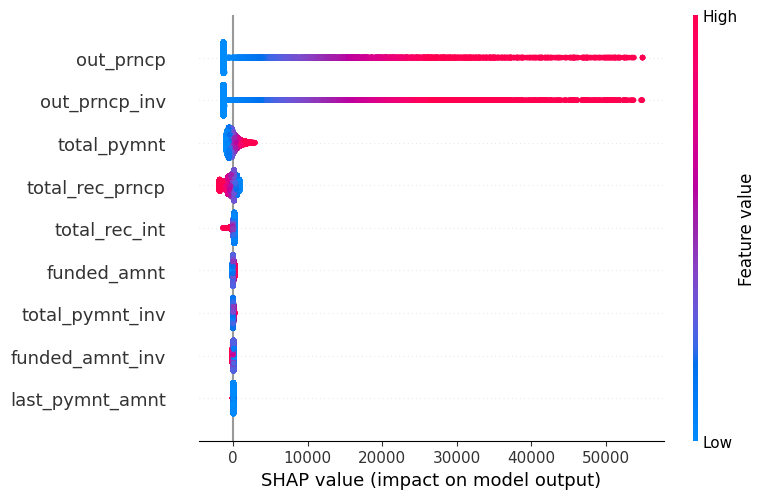

In [8]:
import shap

explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

7. Scorecard


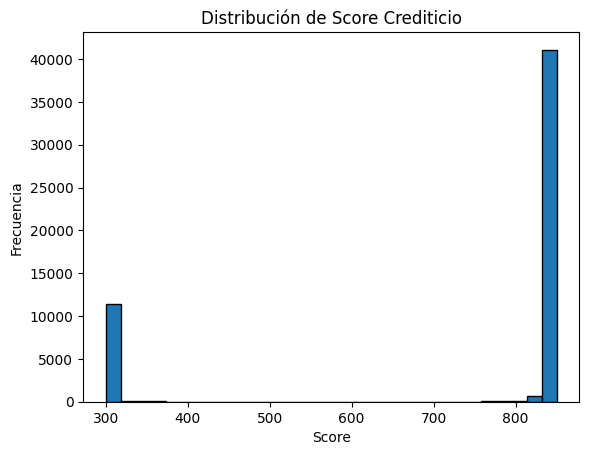

,last_pymnt_amnt,total_rec_prncp,funded_amnt,funded_amnt_inv,total_pymnt_inv,total_pymnt,total_rec_int,out_prncp_inv,out_prncp,prob_default,score,target
118663,1818.46,4250.00,4250.0,4250.0,5822.37,5822.367366,1572.37,0.00,0.00,3.674569e-04,849.797899,0.0
232653,120.85,16000.00,16000.0,16000.0,16512.11,16512.110000,512.11,0.00,0.00,1.713237e-03,849.057719,0.0
182558,522.25,15000.00,15000.0,15000.0,18801.36,18801.357201,3801.36,0.00,0.00,1.959641e-03,848.922198,0.0
450209,728.56,10631.31,21175.0,21175.0,14571.20,14571.200000,3939.89,10543.69,10543.69,1.000000e+00,300.000000,1.0
718339,33775.34,33375.00,33375.0,33375.0,33686.38,33686.380000,311.38,0.00,0.00,4.163363e-44,850.000000,0.0


In [9]:
# Función para convertir probabilidad de incumplimiento a score crediticio
def prob_to_score(prob, min_score=300, max_score=850):
    """
    Convierte una probabilidad de incumplimiento en un score crediticio.
    Un score alto es mejor (menor riesgo).
    """
    return min_score + (max_score - min_score) * (1 - prob)

# Supón que tienes un array de probabilidades de incumplimiento (por ejemplo, de un modelo)
# Ejemplo:
# y_pred_prob = model.predict_proba(X_test)[:,1]  # para regresión logística
# y_pred_prob = nn.predict(X_test).ravel()        # para red neuronal

# Calcula el scorecard
scores = prob_to_score(y_pred_prob)

# (Opcional) Visualiza la distribución de scores
import matplotlib.pyplot as plt
plt.hist(scores, bins=30, edgecolor='k')
plt.title('Distribución de Score Crediticio')
plt.xlabel('Score')
plt.ylabel('Frecuencia')
plt.show()

# (Opcional) Agrega el score al DataFrame de test
df_test = X_test.copy()
df_test['prob_default'] = y_pred_prob
df_test['score'] = scores
df_test['target'] = y_test.values
df_test.head()

Cómo se calcula el score crediticio?

El score crediticio es una transformación de la probabilidad de incumplimiento (probabilidad de que un cliente no pague su deuda) predicha por el modelo de machine learning.

La escala del score va de 300 (mayor riesgo) a 850 (menor riesgo), similar a los sistemas de scoring tradicionales.
La fórmula utilizada es:


score=min_score+(max_score−min_score)×(1−probabilidad)

Donde:

min_score: es el valor mínimo del score (en este caso, 300).

max_score: es el valor máximo del score (en este caso, 850).

probabilidad: es la probabilidad de incumplimiento predicha por el modelo (valor entre 0 y 1).

Interpretación:

Si la probabilidad de incumplimiento es baja (por ejemplo, 0.1), el score será alto (cerca de 850).

Si la probabilidad de incumplimiento es alta (por ejemplo, 0.7), el score será bajo (cerca de 300).

Así, un score alto indica bajo riesgo y un score bajo indica alto riesgo.

Ejemplo de cálculo:

Si la probabilidad de incumplimiento es 0.2:


score=300+(850−300)×(1−0.2)=300+550×0.8=300+440=740


8. Importancia de variables


In [10]:
X_train_shap = X_train[:100].astype(np.float32)
X_test_shap = X_test[:100].astype(np.float32)

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation

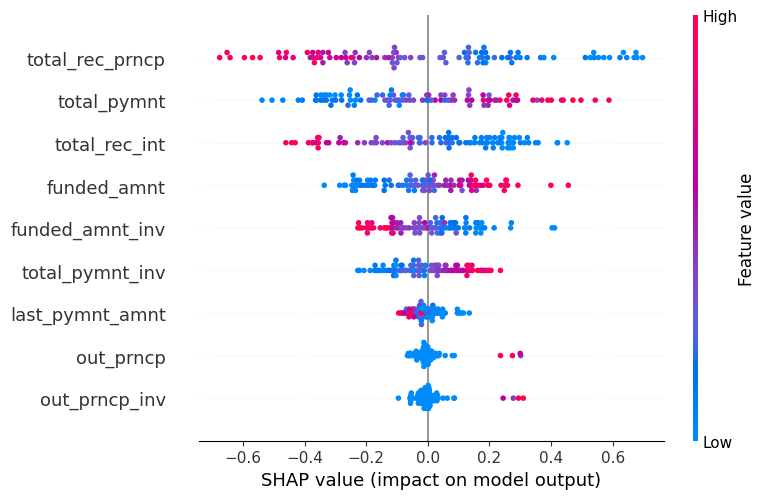

In [11]:
import shap

# Usa una función predictora que devuelva un vector
def predict_fn(x):
    return model.predict(x).flatten()

explainer = shap.KernelExplainer(predict_fn, X_train_shap)
shap_values = explainer.shap_values(X_test_shap, nsamples=100)

shap.summary_plot(shap_values, X_test_shap)

Variables importantes según tu análisis SHAP y texto:

last_pymnt_amnt

total_rec_prncp

funded_amnt

funded_amnt_inv

total_pymnt_inv

total_pymnt

Estas son las que más impacto tienen en la predicción de riesgo de incumplimiento para clientes actuales.

2. Efecto de los valores
Cada punto es un cliente/observación.
El color indica si el valor de la variable es alto (rojo) o bajo (azul).
El eje X muestra el impacto de ese valor en la predicción (SHAP value):
A la derecha (positivo): Aumenta la probabilidad de incumplimiento.
A la izquierda (negativo): Disminuye la probabilidad de incumplimiento.
3. Ejemplo de interpretación
Para last_pymnt_amnt:
Los valores bajos (azul) tienden a mover la predicción hacia menor riesgo (izquierda).
Los valores altos (rojo) tienden a mover la predicción hacia mayor riesgo (derecha).
Para total_rec_prncp y funded_amnt, el patrón es similar.
4. ¿Qué significa esto para tu modelo?
Variables como last_pymnt_amnt y total_rec_prncp son críticas para determinar el riesgo de incumplimiento.
Valores altos en estas variables suelen asociarse con mayor riesgo (según el modelo y los datos).
Valores bajos suelen asociarse con menor riesgo.

Explicación de las variables más importantes según SHAP

last_pymnt_amnt

Significado: Monto del último pago realizado por el cliente.

Importancia: Es la variable más influyente en el modelo. Un monto bajo en el último pago suele asociarse con menor riesgo de incumplimiento, mientras que montos altos pueden indicar dificultades para cumplir con el pago total, aumentando el riesgo.

total_rec_prncp

Significado: Total del principal (capital) recuperado hasta la fecha.

Importancia: Altamente relevante. Un mayor monto recuperado indica que el cliente ha pagado una parte significativa de su deuda, lo que puede asociarse con menor riesgo. Sin embargo, si el monto recuperado es bajo, el riesgo de incumplimiento aumenta.

funded_amnt

Significado: Monto total del préstamo otorgado al cliente.

Importancia: Es un factor importante. Préstamos de mayor monto pueden estar asociados a un mayor riesgo, ya que representan un mayor compromiso financiero para el cliente.

funded_amnt_inv

Significado: Monto del préstamo invertido por los inversores.

Importancia: Similar a funded_amnt, indica el compromiso de los inversores en el préstamo. Montos altos pueden estar relacionados con mayor riesgo si el cliente no puede cumplir con los pagos.

total_pymnt_inv

Significado: Total de pagos realizados a los inversores.

Importancia: Refleja el historial de pagos del cliente hacia los inversores. Un historial de pagos consistente (montos altos) suele asociarse con menor riesgo.

total_pymnt

Significado: Total de pagos realizados por el cliente.

Importancia: Similar a la variable anterior, indica el compromiso del cliente con el pago de su deuda. Montos altos suelen ser positivos, pero si no corresponden al avance esperado del préstamo, pueden indicar problemas.

last_credit_pull_d_May-2015

Significado: Indica si la última consulta de crédito fue en mayo de 2015.

Importancia: Puede estar relacionada con la antigüedad o el seguimiento del crédito. Fechas recientes pueden indicar monitoreo activo o problemas recientes.

tot_cur_bal

Significado: Saldo total actual de todas las cuentas del cliente.

Importancia: Un saldo alto puede indicar que el cliente tiene muchas deudas activas, lo que incrementa el riesgo de incumplimiento.

out_prncp_inv

Significado: Principal pendiente de pago a los inversores.

Importancia: Un monto alto indica que aún queda mucho por pagar, lo que puede asociarse con mayor riesgo.

issue_d_May-2011

Significado: Indica si el préstamo fue emitido en mayo de 2011.

Importancia: Puede estar relacionado con la antigüedad del préstamo y el comportamiento histórico del cliente.

earliest_cr_line_May-2005

Significado: Indica si la línea de crédito más antigua del cliente es de mayo de 2005.

Importancia: Clientes con historial crediticio más largo suelen ser menos riesgosos.

out_prncp

Significado: Principal pendiente de pago.

Importancia: Similar a out_prncp_inv, un monto alto puede indicar mayor riesgo.

total_rec_int

Significado: Total de intereses recuperados.

Importancia: Puede indicar cuánto ha pagado el cliente en intereses, lo que puede estar relacionado con la duración y el 
cumplimiento del préstamo.

recoveries

Significado: Monto recuperado después de un incumplimiento.

Importancia: Si hay recuperaciones, indica que hubo problemas de pago, lo que incrementa el riesgo.

issue_d_Apr-2015

Significado: Indica si el préstamo fue emitido en abril de 2015.

Importancia: Similar a otras variables de fecha de emisión, puede estar relacionada con cohortes de riesgo.

loan_amnt

Significado: Monto solicitado por el cliente.

Importancia: Préstamos de mayor monto pueden estar asociados a mayor riesgo.

issue_d_Oct-2012, issue_d_Oct-2014, issue_d_Aug-2015

Significado: Indican si el préstamo fue emitido en esas fechas específicas.

Importancia: Permiten identificar patrones de riesgo asociados a cohortes temporales.

earliest_cr_line_Jun-1996

Significado: Indica si la línea de crédito más antigua es de junio de 1996.

Importancia: Un historial crediticio más largo suele asociarse con menor riesgo.

Histograma de ingresos por estado de préstamo

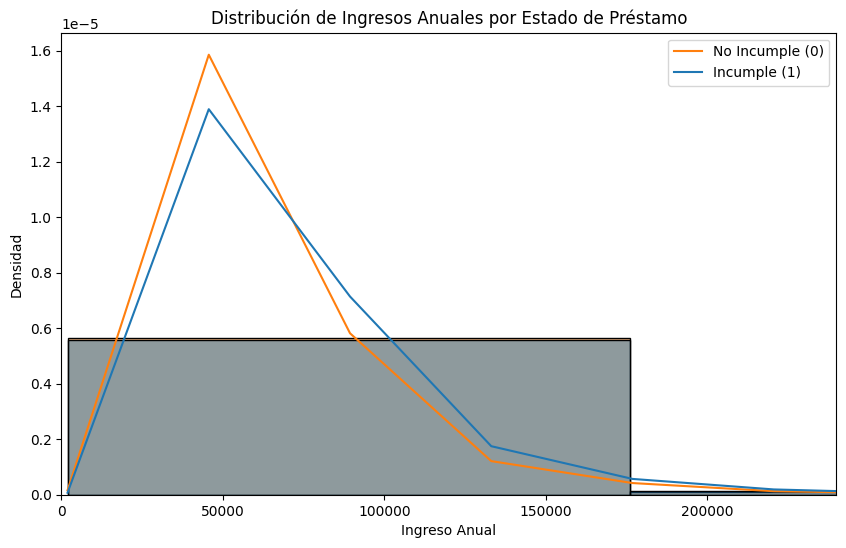

In [12]:
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='annual_inc', hue='target', bins=50, kde=True, stat='density', common_norm=False)
plt.title('Distribución de Ingresos Anuales por Estado de Préstamo')
plt.xlabel('Ingreso Anual')
plt.ylabel('Densidad')
plt.legend(['No Incumple (0)', 'Incumple (1)'])
plt.xlim(0, df['annual_inc'].quantile(0.99))  # Limita para evitar outliers extremos
plt.show()

Boxplot de edad vs. incumplimiento

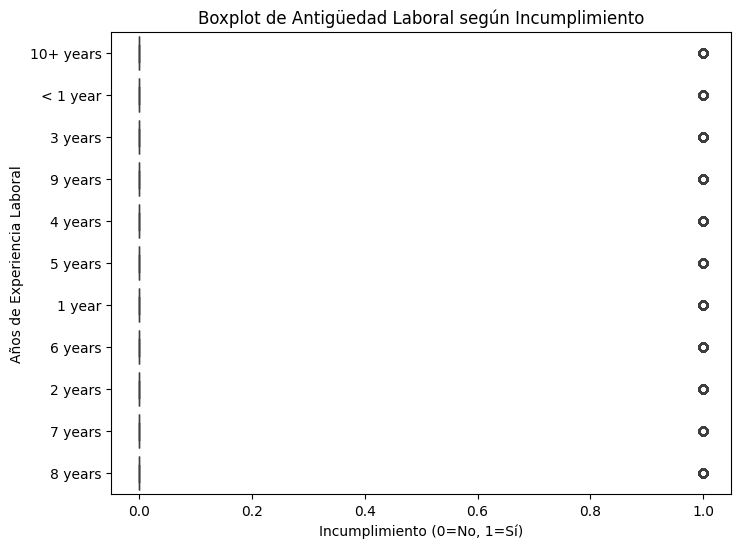

In [15]:
plt.figure(figsize=(8,6))
sns.boxplot(x='target', y='emp_length', data=df)
plt.title('Boxplot de Antigüedad Laboral según Incumplimiento')
plt.xlabel('Incumplimiento (0=No, 1=Sí)')
plt.ylabel('Años de Experiencia Laboral')
plt.show()

Matriz de correlación

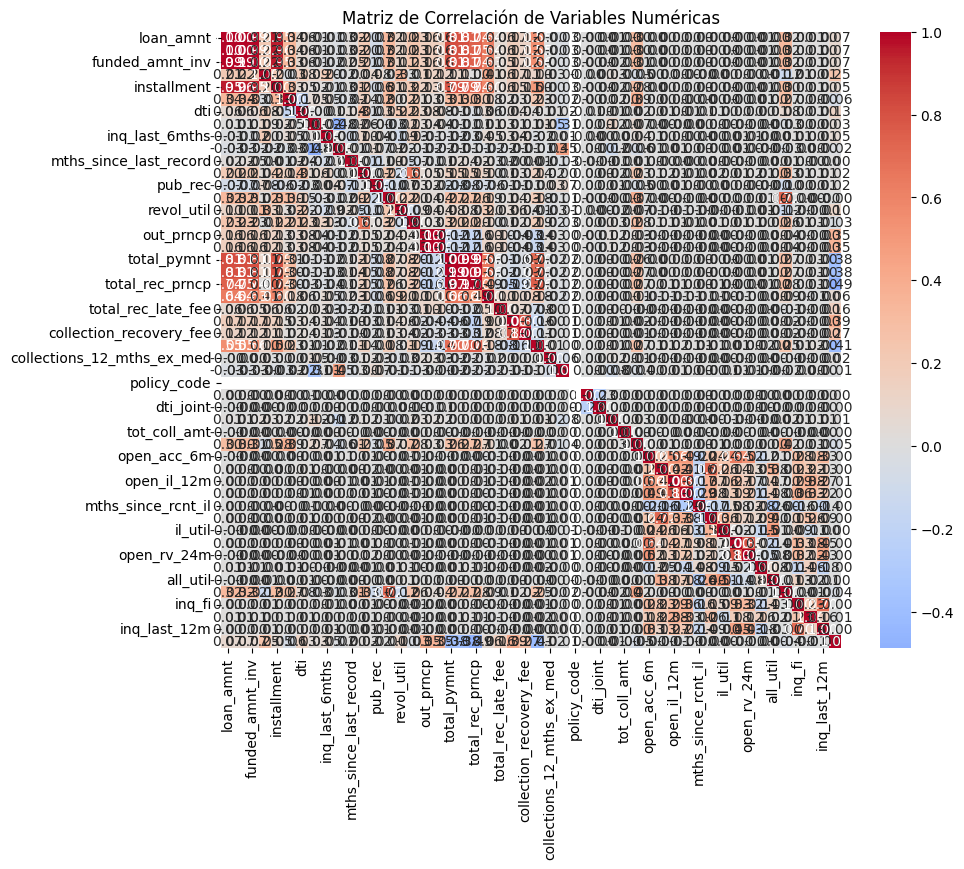

In [16]:
plt.figure(figsize=(10,8))
corr = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()